# Environment Setup

In [ ]:
import torch
torch.cuda.empty_cache()



In [ ]:
!pip install transformers datasets scikit-learn matplotlib seaborn torch
!pip install evaluate --quiet


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 32.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 25.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 29.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 6.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 11.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 6.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 7.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 60.9 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstalling nvidia-nvjitlink-cu12-12.5.82:
      Successfully uninstalled nvidia-nvjitlin

# 1. Load and Preprocess Data
### 1.1 Upload and Load BRIGHTER Dataset

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

import pandas as pd

# Paths to dev sets
zulu_train = pd.read_parquet('/content/drive/Shareddrives/COS 760 Group 13 Project/Data/Zulu/dev-00000-of-00001.parquet')
xhosa_train = pd.read_parquet('/content/drive/Shareddrives/COS 760 Group 13 Project/Data/Xhosa/dev-00000-of-00001.parquet')
swahili_train = pd.read_parquet('/content/drive/Shareddrives/COS 760 Group 13 Project/Data/Swahili/dev-00000-of-00001.parquet')

# Paths to test sets
zulu_test = pd.read_parquet('/content/drive/Shareddrives/COS 760 Group 13 Project/Data/Zulu/test-00000-of-00001.parquet')
xhosa_test = pd.read_parquet('/content/drive/Shareddrives/COS 760 Group 13 Project/Data/Xhosa/test-00000-of-00001.parquet')
swahili_test = pd.read_parquet('/content/drive/Shareddrives/COS 760 Group 13 Project/Data/Swahili/test-00000-of-00001.parquet')


Mounted at /content/drive


### 1.2 Preprocess: Clean, Normalize, Tokenize

In [ ]:
import re

def clean_text(text):
    text = re.sub(r"[^a-zA-Z0-9\s]", "", text.lower())
    return text.strip()

for df in [zulu_train, xhosa_train, swahili_train, zulu_test, xhosa_test, swahili_test]:
    df['text'] = df['text'].apply(clean_text)


# 2. Prepare Multi-label Format

In [ ]:
import pandas as pd
from datasets import Dataset, DatasetDict

emotion_labels = ["anger","disgust","fear","joy","sadness","surprise"]

def preprocess(df, lan):
    return {
        'text': df['text'].tolist(),
        'labels': df[emotion_labels].astype(float).values.tolist(),
        'language': [lan] * len(df)
    }



zulu = {
    "train" :  (preprocess(zulu_train, 'zulu')),
    "test" :  (preprocess(zulu_test, 'zulu')),
}

xhosa = {
    "train" :  (preprocess(xhosa_train, 'xhosa')),
    "test" :  (preprocess(xhosa_test, 'xhosa')),
}

swahili = {
    "train" :  (preprocess(swahili_train, 'swahili')),
    "test" :  (preprocess(swahili_test, 'swahili')),
}



# 3. Fine-tune AfriBERTa, XLM-R and Serengeti-E250


In [ ]:
from transformers import AutoTokenizer, AutoModelForSequenceClassification

afriberta = 'castorini/afriberta_large'
xlmr = 'xlm-roberta-large'
serengeti = 'UBC-NLP/serengeti-E250'

tokenizer_afri = AutoTokenizer.from_pretrained(afriberta)
tokenizer_xlmr = AutoTokenizer.from_pretrained(xlmr)
tokenizer_serengeti = AutoTokenizer.from_pretrained(serengeti)

model_afri = AutoModelForSequenceClassification.from_pretrained(
    afriberta,
    num_labels=len(emotion_labels),
    problem_type="multi_label_classification"
)

model_xlmr = AutoModelForSequenceClassification.from_pretrained(
    xlmr,
    num_labels=len(emotion_labels),
    problem_type="multi_label_classification"
)

model_serengeti = AutoModelForSequenceClassification.from_pretrained(
    serengeti,
    num_labels=len(emotion_labels),
    problem_type="multi_label_classification"
)

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/257 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/731 [00:00<?, ?B/s]

sentencepiece.bpe.model:   0%|          | 0.00/1.55M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/150 [00:00<?, ?B/s]

/usr/local/lib/python3.11/dist-packages/transformers/convert_slow_tokenizer.py:564: UserWarning: The sentencepiece tokenizer that you are converting to a fast tokenizer uses the byte fallback option which is not implemented in the fast tokenizers. In practice this means that the fast version of the tokenizer can produce unknown tokens whereas the sentencepiece version would have converted these unknown tokens into a sequence of byte tokens matching the original piece of text.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/615 [00:00<?, ?B/s]

sentencepiece.bpe.model:   0%|          | 0.00/5.07M [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/9.10M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/1.30k [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/2.14M [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/6.28M [00:00<?, ?B/s]

added_tokens.json:   0%|          | 0.00/74.0 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/125 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/503M [00:00<?, ?B/s]

Some weights of XLMRobertaForSequenceClassification were not initialized from the model checkpoint at castorini/afriberta_large and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


model.safetensors:   0%|          | 0.00/503M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.12G [00:00<?, ?B/s]

Some weights of XLMRobertaForSequenceClassification were not initialized from the model checkpoint at xlm-roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


config.json:   0%|          | 0.00/733 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/1.11G [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.11G [00:00<?, ?B/s]

Some weights of ElectraForSequenceClassification were not initialized from the model checkpoint at UBC-NLP/serengeti-E250 and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


#4 Tokenize Dataset

In [ ]:
import pandas as pd
from datasets import Dataset, DatasetDict


def tokenize_data(tokenizer, texts, labels):
    encodings = tokenizer(texts, truncation=True, padding=True, max_length=512)
    encodings['labels'] = labels
 e
    return encodings

## 4.1 Tokenize the Dataset Zulu


In [ ]:
def tokenize_data(tokenizer, texts, labels):
    encodings = tokenizer(texts, truncation=True, padding=True, max_length=512)
    encodings['labels'] = labels
    return encodings

train_encodings_afri_zulu = tokenize_data(tokenizer_afri, zulu['train']['text'], zulu['train']['labels'])
test_encodings_afri_zulu = tokenize_data(tokenizer_afri, zulu['test']['text'], zulu['test']['labels'])

train_encodings_xlmr_zulu = tokenize_data(tokenizer_xlmr, zulu['train']['text'], zulu['train']['labels'])
test_encodings_xlmr_zulu = tokenize_data(tokenizer_xlmr, zulu['test']['text'], zulu['test']['labels'])

train_encodings_serengeti_zulu = tokenize_data(tokenizer_serengeti, zulu['train']['text'], zulu['train']['labels'])
test_encodings_serengeti_zulu = tokenize_data(tokenizer_serengeti, zulu['test']['text'], zulu['test']['labels'])


##4.2 Tokenize the Dataset Xhosa

In [ ]:
def tokenize_data(tokenizer, texts, labels):
    encodings = tokenizer(texts, truncation=True, padding=True, max_length=512)
    encodings['labels'] = labels
    return encodings

train_encodings_afri_xhosa = tokenize_data(tokenizer_afri, xhosa['train']['text'], xhosa['train']['labels'])
test_encodings_afri_xhosa = tokenize_data(tokenizer_afri, xhosa['test']['text'], xhosa['test']['labels'])

train_encodings_xlmr_xhosa = tokenize_data(tokenizer_xlmr, xhosa['train']['text'], xhosa['train']['labels'])
test_encodings_xlmr_xhosa = tokenize_data(tokenizer_xlmr, xhosa['test']['text'], xhosa['test']['labels'])

train_encodings_serengeti_xhosa = tokenize_data(tokenizer_serengeti, xhosa['train']['text'], xhosa['train']['labels'])
test_encodings_serengeti_xhosa = tokenize_data(tokenizer_serengeti, xhosa['test']['text'], xhosa['test']['labels'])

##4.3 Tokenize the Dataset Swahili

In [ ]:
def tokenize_data(tokenizer, texts, labels):
    encodings = tokenizer(texts, truncation=True, padding=True, max_length=512)
    encodings['labels'] = labels
    return encodings

train_encodings_afri_swahili = tokenize_data(tokenizer_afri, swahili['train']['text'], swahili['train']['labels'])
test_encodings_afri_swahili = tokenize_data(tokenizer_afri, swahili['test']['text'], swahili['test']['labels'])

train_encodings_xlmr_swahili = tokenize_data(tokenizer_xlmr, swahili['train']['text'], swahili['train']['labels'])
test_encodings_xlmr_swahili = tokenize_data(tokenizer_xlmr, swahili['test']['text'], swahili['test']['labels'])

train_encodings_serengeti_swahili = tokenize_data(tokenizer_serengeti, swahili['train']['text'], swahili['train']['labels'])
test_encodings_serengeti_swahili = tokenize_data(tokenizer_serengeti, swahili['test']['text'], swahili['test']['labels'])

# 5. Convert to Dataset Format

In [ ]:
import torch
from torch.utils.data import Dataset

class EmotionDataset(Dataset):
    def __init__(self, encodings):
        self.encodings = encodings

    def __len__(self):
        return len(self.encodings['input_ids'])

    def __getitem__(self, idx):
      item = {k: torch.tensor(v[idx]) for k, v in self.encodings.items()}
      item['labels'] = item['labels'].float()  # ✅ Cast labels to float
      return item

#zulu
train_dataset_afri_zulu = EmotionDataset(train_encodings_afri_zulu)
test_dataset_afri_zulu = EmotionDataset(test_encodings_afri_zulu)

train_dataset_xlmr_zulu = EmotionDataset(train_encodings_xlmr_zulu)
test_dataset_xlmr_zulu = EmotionDataset(test_encodings_xlmr_zulu)

train_dataset_serengeti_zulu = EmotionDataset(train_encodings_serengeti_zulu)
test_dataset_serengeti_zulu = EmotionDataset(test_encodings_serengeti_zulu)
#xhosa
train_dataset_afri_xhosa = EmotionDataset(train_encodings_afri_xhosa)
test_dataset_afri_xhosa = EmotionDataset(test_encodings_afri_xhosa)

train_dataset_xlmr_xhosa = EmotionDataset(train_encodings_xlmr_xhosa)
test_dataset_xlmr_xhosa = EmotionDataset(test_encodings_xlmr_xhosa)

train_dataset_serengeti_xhosa = EmotionDataset(train_encodings_serengeti_xhosa)
test_dataset_serengeti_xhosa = EmotionDataset(test_encodings_serengeti_xhosa)

#swahili
train_dataset_afri_swahili = EmotionDataset(train_encodings_afri_swahili)
test_dataset_afri_swahili = EmotionDataset(test_encodings_afri_swahili)

train_dataset_xlmr_swahili = EmotionDataset(train_encodings_xlmr_swahili)
test_dataset_xlmr_swahili = EmotionDataset(test_encodings_xlmr_swahili)

train_dataset_serengeti_swahili = EmotionDataset(train_encodings_serengeti_swahili)
test_dataset_serengeti_swahili = EmotionDataset(test_encodings_serengeti_swahili)



# 6. Train Models

In [ ]:
from transformers import Trainer, TrainingArguments, EvalPrediction
from dataclasses import replace
import numpy as np
from sklearn.metrics import f1_score,roc_auc_score,hamming_loss

def multi_lables_metrics(predictions,labels,threshold = 0.3):
    sigmoid = torch.nn.Sigmoid()
    probs = sigmoid(torch.tensor(predictions))
    preds = np.zeros(probs.shape)
    preds[np.where(probs >= 0.3)] = 1
    true = labels

    f1 = f1_score(true, preds, average='micro')
    roc_auc = roc_auc_score(true, probs, average='micro')
    hamming = hamming_loss(true, preds)

    return {
        'f1': f1,
        'roc_auc': roc_auc,
        'hamming_loss': hamming
    }

def compute_metrics(eval_pred):
    predictions, labels = eval_pred
    return multi_lables_metrics(predictions,labels)


## 6.1 AfriBerta Training Setup

In [ ]:
training_args_afri = TrainingArguments(
    output_dir="/content/drive/Shareddrives/COS 760 Group 13 Project/BaseModels",
    eval_strategy="epoch",
    save_strategy="epoch",
    save_steps = 1000,
    save_total_limit=3,
    learning_rate=1e-5,
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    num_train_epochs=3,
    weight_decay=0.01,
    load_best_model_at_end=True,
    metric_for_best_model='roc_auc',
    logging_dir=f'/content/drive/Shareddrives/COS 760 Group 13 Project/BaseModels/logs',
    logging_steps=100,
    run_name="afriberta_run"
)

# Zulu
training_args_afri_zulu = replace(
    training_args_afri,
    output_dir="/content/drive/Shareddrives/COS 760 Group 13 Project/BaseModels/afriberta_zulu",
    logging_dir=f'/content/drive/Shareddrives/COS 760 Group 13 Project/BaseModels/afriberta_zulu/logs',
    run_name="afriberta_zulu_run"
)
trainer_afri_zulu = Trainer(
    model=model_afri,
    args=training_args_afri_zulu,
    train_dataset=train_dataset_afri_zulu,
    eval_dataset=test_dataset_afri_zulu,
    compute_metrics=compute_metrics
)
# Xhosa
training_args_afri_xhosa = replace(
    training_args_afri,
    output_dir="/content/drive/Shareddrives/COS 760 Group 13 Project/BaseModels/afriberta_xhosa",
    logging_dir=f'/content/drive/Shareddrives/COS 760 Group 13 Project/BaseModels/afriberta_xhosa/logs',
    run_name="afriberta_xhosa_run"
)
trainer_afri_xhosa = Trainer(
    model=model_afri,
    args=training_args_afri_xhosa,
    train_dataset=train_dataset_afri_xhosa,
    eval_dataset=test_dataset_afri_xhosa,
    compute_metrics=compute_metrics
)

# Swahili
training_args_afri_swahili = replace(
    training_args_afri,
    output_dir="/content/drive/Shareddrives/COS 760 Group 13 Project/BaseModels/afriberta_swahili",
    logging_dir=f'/content/drive/Shareddrives/COS 760 Group 13 Project/BaseModels/afriberta_swahili/logs',
    run_name="afriberta_swahili_run"
)
trainer_afri_swahili = Trainer(
    model=model_afri,
    args=training_args_afri_swahili,
    train_dataset=train_dataset_afri_swahili,
    eval_dataset=test_dataset_afri_swahili,
    compute_metrics=compute_metrics
)


## 6.2 XLMR Training Setup

In [ ]:
training_args_xlmr = TrainingArguments(
    output_dir="/content/drive/Shareddrives/COS 760 Group 13 Project/BaseModels",
    eval_strategy="epoch",
    save_strategy="epoch",
    save_steps = 1000,
    save_total_limit=3,
    learning_rate=1e-5,
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    num_train_epochs=3,
    weight_decay=0.01,
    load_best_model_at_end=True,
    metric_for_best_model='roc_auc',
    logging_dir=f'/content/drive/Shareddrives/COS 760 Group 13 Project/BaseModels/logs',
    logging_steps=100,
    run_name="xlmr_run"
)

# Zulu
training_args_xlmr_zulu = replace(
    training_args_xlmr,
    output_dir="/content/drive/Shareddrives/COS 760 Group 13 Project/BaseModels/xlmr_zulu",
    logging_dir=f'/content/drive/Shareddrives/COS 760 Group 13 Project/BaseModels/xlmr_zulu/logs',
    run_name="xlmr_zulu_run"
)
trainer_xlmr_zulu = Trainer(
    model=model_xlmr,
    args=training_args_xlmr_zulu,
    train_dataset=train_dataset_xlmr_zulu,
    eval_dataset=test_dataset_xlmr_zulu,
    compute_metrics=compute_metrics
)

# Xhosa
training_args_xlmr_xhosa = replace(
    training_args_xlmr,
    output_dir="/content/drive/Shareddrives/COS 760 Group 13 Project/BaseModels/xlmr_xhosa",
    logging_dir=f'/content/drive/Shareddrives/COS 760 Group 13 Project/BaseModels/xlmr_xhosa/logs',
    run_name="xlmr_xhosa_run"
)
trainer_xlmr_xhosa = Trainer(
    model=model_xlmr,
    args=training_args_xlmr_xhosa,
    train_dataset=train_dataset_xlmr_xhosa,
    eval_dataset=test_dataset_xlmr_xhosa,
    compute_metrics=compute_metrics
)

# Swahili
training_args_xlmr_swahili = replace(
    training_args_xlmr,
    output_dir="/content/drive/Shareddrives/COS 760 Group 13 Project/BaseModels/xlmr_swahili",
    logging_dir=f'/content/drive/Shareddrives/COS 760 Group 13 Project/BaseModels/xlmr_swahili/logs',
    run_name="xlmr_swahili_run"
)
trainer_xlmr_swahili = Trainer(
    model=model_xlmr,
    args=training_args_xlmr_swahili,
    train_dataset=train_dataset_xlmr_swahili,
    eval_dataset=test_dataset_xlmr_swahili,
    compute_metrics=compute_metrics
)

## 6.3 Serengeti Training Setup

In [ ]:
training_args_serengeti = TrainingArguments(
    output_dir="/content/drive/Shareddrives/COS 760 Group 13 Project/BaseModels",
    eval_strategy="epoch",
    save_strategy="epoch",
    save_steps = 1000,
    save_total_limit=3,
    learning_rate=1e-5,
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    num_train_epochs=3,
    weight_decay=0.01,
    load_best_model_at_end=True,
    metric_for_best_model='roc_auc',
    logging_dir=f'/content/drive/Shareddrives/COS 760 Group 13 Project/BaseModels/logs',
    logging_steps=100,
    run_name="serengeti_run"
)

# Zulu
training_args_serengeti_zulu = replace(
    training_args_serengeti,
    output_dir="/content/drive/Shareddrives/COS 760 Group 13 Project/BaseModels/serengeti_zulu",
    logging_dir=f'/content/drive/Shareddrives/COS 760 Group 13 Project/BaseModels/serengeti_zulu/logs',
    run_name="serengeti_zulu_run"
)
trainer_serengeti_zulu = Trainer(
    model=model_serengeti,
    args=training_args_serengeti_zulu,
    train_dataset=train_dataset_serengeti_zulu,
    eval_dataset=test_dataset_serengeti_zulu,
    compute_metrics=compute_metrics
)

# Xhosa
training_args_serengeti_xhosa = replace(
    training_args_serengeti,
    output_dir="/content/drive/Shareddrives/COS 760 Group 13 Project/BaseModels/serengeti_xhosa",
    logging_dir=f'/content/drive/Shareddrives/COS 760 Group 13 Project/BaseModels/serengeti_xhosa/logs',
    run_name="serengeti_xhosa_run"
)
trainer_serengeti_xhosa = Trainer(
    model=model_serengeti,
    args=training_args_serengeti_xhosa,
    train_dataset=train_dataset_serengeti_xhosa,
    eval_dataset=test_dataset_serengeti_xhosa,
    compute_metrics=compute_metrics
)

# Swahili
training_args_serengeti_swahili = replace(
    training_args_serengeti,
    output_dir="/content/drive/Shareddrives/COS 760 Group 13 Project/BaseModels/serengeti_swahili",
    logging_dir=f'/content/drive/Shareddrives/COS 760 Group 13 Project/BaseModels/serengeti_swahili/logs',
    run_name="serengeti_swahili_run"
)
trainer_serengeti_swahili = Trainer(
    model=model_serengeti,
    args=training_args_serengeti_swahili,
    train_dataset=train_dataset_serengeti_swahili,
    eval_dataset=test_dataset_serengeti_swahili,
    compute_metrics=compute_metrics
)

## 6.4 Train all models

In [ ]:
import gc
import torch
from transformers import Trainer

def train_and_save(model, tokenizer, training_args, train_dataset, eval_dataset, output_dir):
    trainer = Trainer(
        model=model,
        args=training_args,
        train_dataset=train_dataset,
        eval_dataset=eval_dataset,
        compute_metrics=compute_metrics
    )
    trainer.train()
    trainer.save_model(f"{output_dir}/final_base_model")
    tokenizer.save_pretrained(f"{output_dir}/final_base_model")

    # Free up memory
    del trainer
    del model
    gc.collect()
    torch.cuda.empty_cache()


In [ ]:
# AfriBERTa
train_and_save(model_afri, tokenizer_afri, training_args_afri_zulu, train_dataset_afri_zulu, test_dataset_afri_zulu, "/content/drive/Shareddrives/COS 760 Group 13 Project/Models/afriberta_zulu")
train_and_save(model_afri, tokenizer_afri, training_args_afri_xhosa, train_dataset_afri_xhosa, test_dataset_afri_xhosa, "/content/drive/Shareddrives/COS 760 Group 13 Project/Models/afriberta_xhosa")
train_and_save(model_afri, tokenizer_afri, training_args_afri_swahili, train_dataset_afri_swahili, test_dataset_afri_swahili, "/content/drive/Shareddrives/COS 760 Group 13 Project/Models/afriberta_swahili")

# # XLM-R
train_and_save(model_xlmr, tokenizer_xlmr, training_args_xlmr_zulu, train_dataset_xlmr_zulu, test_dataset_xlmr_zulu, "/content/drive/Shareddrives/COS 760 Group 13 Project/Models/xlmr_zulu")
train_and_save(model_xlmr, tokenizer_xlmr, training_args_xlmr_xhosa, train_dataset_xlmr_xhosa, test_dataset_xlmr_xhosa, "/content/drive/Shareddrives/COS 760 Group 13 Project/Models/xlmr_xhosa")
train_and_save(model_xlmr, tokenizer_xlmr, training_args_xlmr_swahili, train_dataset_xlmr_swahili, test_dataset_xlmr_swahili, "/content/drive/Shareddrives/COS 760 Group 13 Project/Models/xlmr_swahili")

# # Serengeti
train_and_save(model_serengeti, tokenizer_serengeti, training_args_serengeti_zulu, train_dataset_serengeti_zulu, test_dataset_serengeti_zulu, "/content/drive/Shareddrives/COS 760 Group 13 Project/Models/serengeti_zulu")
train_and_save(model_serengeti, tokenizer_serengeti, training_args_serengeti_xhosa, train_dataset_serengeti_xhosa, test_dataset_serengeti_xhosa, "/content/drive/Shareddrives/COS 760 Group 13 Project/Models/serengeti_xhosa")
train_and_save(model_serengeti, tokenizer_serengeti, training_args_serengeti_swahili, train_dataset_serengeti_swahili, test_dataset_serengeti_swahili, "/content/drive/Shareddrives/COS 760 Group 13 Project/Models/serengeti_swahili")


<IPython.core.display.Javascript object>

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize?ref=models
wandb: Paste an API key from your profile and hit enter:

 ··········


wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: No netrc file found, creating one.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
wandb: Currently logged in as: u21668452 (u21668452-university-of-pretoria) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


Epoch,Training Loss,Validation Loss,F1,Roc Auc,Hamming Loss,Runtime,Samples Per Second,Steps Per Second
1,0.326600,0.265224,0.000000,0.710687,0.083048,9.632400,212.512000,26.577000
2,0.260800,0.262510,0.000000,0.716038,0.083048,10.340600,197.957000,24.757000
3,0.254600,0.258486,0.145069,0.724854,0.085410,10.652800,192.155000,24.031000


/usr/local/lib/python3.11/dist-packages/transformers/configuration_utils.py:394: UserWarning: Some non-default generation parameters are set in the model config. These should go into either a) `model.generation_config` (as opposed to `model.config`); OR b) a GenerationConfig file (https://huggingface.co/docs/transformers/generation_strategies#save-a-custom-decoding-strategy-with-your-model).This warning will become an exception in the future.
Non-default generation parameters: {'max_length': 512}
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/transformers/configuration_utils.py:394: UserWarning: Some non-default generation parameters are set in the model config. These should go into either a) `model.generation_config` (as opposed to `model.config`); OR b) a GenerationConfig file (https://huggingface.co/docs/transformers/generation_strategies#save-a-custom-decoding-strategy-with-your-model).This warning will become an exception in the future.
Non-default generation parameters:

Epoch,Training Loss,Validation Loss,F1,Roc Auc,Hamming Loss,Runtime,Samples Per Second,Steps Per Second
1,No log,0.333240,0.496416,0.836606,0.198348,5.934300,268.610000,33.703000
2,0.345000,0.319476,0.521077,0.852737,0.171058,6.383400,249.710000,31.331000
3,0.316200,0.318417,0.520941,0.853246,0.174613,5.947900,267.994000,33.625000


/usr/local/lib/python3.11/dist-packages/transformers/configuration_utils.py:394: UserWarning: Some non-default generation parameters are set in the model config. These should go into either a) `model.generation_config` (as opposed to `model.config`); OR b) a GenerationConfig file (https://huggingface.co/docs/transformers/generation_strategies#save-a-custom-decoding-strategy-with-your-model).This warning will become an exception in the future.
Non-default generation parameters: {'max_length': 512}
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/transformers/configuration_utils.py:394: UserWarning: Some non-default generation parameters are set in the model config. These should go into either a) `model.generation_config` (as opposed to `model.config`); OR b) a GenerationConfig file (https://huggingface.co/docs/transformers/generation_strategies#save-a-custom-decoding-strategy-with-your-model).This warning will become an exception in the future.
Non-default generation parameters:

Epoch,Training Loss,Validation Loss,F1,Roc Auc,Hamming Loss,Runtime,Samples Per Second,Steps Per Second
1,0.311700,0.310400,0.000000,0.657270,0.099738,14.406200,229.901000,28.738000
2,0.297400,0.307752,0.089631,0.666807,0.104267,14.107000,234.778000,29.347000
3,0.258700,0.308662,0.126958,0.665835,0.106582,14.189400,233.413000,29.177000


/usr/local/lib/python3.11/dist-packages/transformers/configuration_utils.py:394: UserWarning: Some non-default generation parameters are set in the model config. These should go into either a) `model.generation_config` (as opposed to `model.config`); OR b) a GenerationConfig file (https://huggingface.co/docs/transformers/generation_strategies#save-a-custom-decoding-strategy-with-your-model).This warning will become an exception in the future.
Non-default generation parameters: {'max_length': 512}
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/transformers/configuration_utils.py:394: UserWarning: Some non-default generation parameters are set in the model config. These should go into either a) `model.generation_config` (as opposed to `model.config`); OR b) a GenerationConfig file (https://huggingface.co/docs/transformers/generation_strategies#save-a-custom-decoding-strategy-with-your-model).This warning will become an exception in the future.
Non-default generation parameters:

Epoch,Training Loss,Validation Loss,F1,Roc Auc,Hamming Loss,Runtime,Samples Per Second,Steps Per Second
1,0.377600,0.267343,0.000000,0.698762,0.083048,10.498800,194.974000,24.384000
2,0.268600,0.267329,0.000000,0.696347,0.083048,10.757600,190.285000,23.797000
3,0.266800,0.266233,0.000000,0.700678,0.083048,10.682000,191.630000,23.965000


Epoch,Training Loss,Validation Loss,F1,Roc Auc,Hamming Loss,Runtime,Samples Per Second,Steps Per Second
1,No log,0.345433,0.490638,0.821906,0.250314,5.350300,297.926000,37.381000
2,0.352200,0.340017,0.486953,0.824455,0.248745,5.310200,300.179000,37.664000
3,0.340600,0.338469,0.481816,0.825814,0.233898,5.342000,298.388000,37.439000


Epoch,Training Loss,Validation Loss,F1,Roc Auc,Hamming Loss,Runtime,Samples Per Second,Steps Per Second
1,0.320500,0.316802,0.000000,0.642665,0.099738,14.969800,221.245000,27.656000
2,0.318800,0.314661,0.000000,0.645283,0.099738,15.415000,214.855000,26.857000
3,0.313200,0.313683,0.000000,0.647914,0.099738,15.329400,216.055000,27.007000


Epoch,Training Loss,Validation Loss,F1,Roc Auc,Hamming Loss,Runtime,Samples Per Second,Steps Per Second
1,0.438500,0.298080,0.000000,0.720086,0.083048,8.680800,235.808000,29.490000
2,0.291200,0.268168,0.028874,0.733785,0.082153,7.952200,257.413000,32.192000
3,0.271100,0.260346,0.351515,0.733717,0.078407,7.873500,259.986000,32.514000


Epoch,Training Loss,Validation Loss,F1,Roc Auc,Hamming Loss,Runtime,Samples Per Second,Steps Per Second
1,No log,0.321492,0.569793,0.860328,0.141468,4.139000,385.118000,48.321000
2,0.344300,0.307082,0.585963,0.875068,0.134463,4.290500,371.517000,46.614000
3,0.311600,0.309761,0.573458,0.869660,0.138122,4.288200,371.716000,46.639000


Epoch,Training Loss,Validation Loss,F1,Roc Auc,Hamming Loss,Runtime,Samples Per Second,Steps Per Second
1,0.317000,0.308882,0.000000,0.665882,0.100342,12.892100,256.902000,32.113000
2,0.304300,0.306604,0.112628,0.678307,0.104670,13.426700,246.672000,30.834000
3,0.277800,0.305807,0.128162,0.676725,0.104066,13.351800,248.057000,31.007000


## 6.5 Evaluate Base Models

In [ ]:
def evaluate_and_report(name, trainer):
    print(f"\n📊 Evaluation Results for {name}")
    results = trainer.evaluate()
    for metric, value in results.items():
        print(f"{metric}: {value:.4f}")
    return results

afri_results_zulu = evaluate_and_report("AfriBERTa zulu", trainer_afri_zulu)
afri_results_xhosa = evaluate_and_report("AfriBERTa xhosa", trainer_afri_xhosa)
afri_results_swahili = evaluate_and_report("AfriBERTa swahili", trainer_afri_swahili)
xlmr_results_zulu = evaluate_and_report("XLM-R zulu", trainer_xlmr_zulu)
xlmr_results_xhosa = evaluate_and_report("XLM-R xhosa", trainer_xlmr_xhosa)
xlmr_results_swahili = evaluate_and_report("XLM-R swahili", trainer_xlmr_swahili)
serengeti_results_zulu = evaluate_and_report("Serengeti zulu", trainer_serengeti_zulu)
serengeti_results_xhosa = evaluate_and_report("Serengeti xhosa", trainer_serengeti_xhosa)
serengeti_results_swahili = evaluate_and_report("Serengeti swahili", trainer_serengeti_swahili)



📊 Evaluation Results for AfriBERTa zulu


eval_loss: 0.2767
eval_model_preparation_time: 0.0261
eval_f1: 0.2954
eval_roc_auc: 0.7332
eval_hamming_loss: 0.1523
eval_runtime: 11.3331
eval_samples_per_second: 180.6210
eval_steps_per_second: 22.5890

📊 Evaluation Results for AfriBERTa xhosa


eval_loss: 0.3746
eval_model_preparation_time: 0.0092
eval_f1: 0.4298
eval_roc_auc: 0.7743
eval_hamming_loss: 0.1779
eval_runtime: 5.8689
eval_samples_per_second: 271.6010
eval_steps_per_second: 34.0780

📊 Evaluation Results for AfriBERTa swahili


eval_loss: 0.3078
eval_model_preparation_time: 0.0028
eval_f1: 0.0896
eval_roc_auc: 0.6668
eval_hamming_loss: 0.1043
eval_runtime: 13.7458
eval_samples_per_second: 240.9470
eval_steps_per_second: 30.1180

📊 Evaluation Results for XLM-R zulu


eval_loss: 0.2847
eval_model_preparation_time: 0.0028
eval_f1: 0.0000
eval_roc_auc: 0.5864
eval_hamming_loss: 0.0830
eval_runtime: 10.3684
eval_samples_per_second: 197.4270
eval_steps_per_second: 24.6900

📊 Evaluation Results for XLM-R xhosa


eval_loss: 0.4348
eval_model_preparation_time: 0.0047
eval_f1: 0.0000
eval_roc_auc: 0.7147
eval_hamming_loss: 0.1581
eval_runtime: 5.2109
eval_samples_per_second: 305.8960
eval_steps_per_second: 38.3810

📊 Evaluation Results for XLM-R swahili


eval_loss: 0.3137
eval_model_preparation_time: 0.0028
eval_f1: 0.0000
eval_roc_auc: 0.6479
eval_hamming_loss: 0.0997
eval_runtime: 14.8540
eval_samples_per_second: 222.9710
eval_steps_per_second: 27.8710

📊 Evaluation Results for Serengeti zulu


eval_loss: 0.2645
eval_model_preparation_time: 0.0027
eval_f1: 0.3540
eval_roc_auc: 0.7609
eval_hamming_loss: 0.1394
eval_runtime: 8.2230
eval_samples_per_second: 248.9360
eval_steps_per_second: 31.1320

📊 Evaluation Results for Serengeti xhosa


eval_loss: 0.3589
eval_model_preparation_time: 0.0029
eval_f1: 0.4433
eval_roc_auc: 0.7793
eval_hamming_loss: 0.1576
eval_runtime: 5.1752
eval_samples_per_second: 308.0100
eval_steps_per_second: 38.6460

📊 Evaluation Results for Serengeti swahili


eval_loss: 0.3066
eval_model_preparation_time: 0.0047
eval_f1: 0.1126
eval_roc_auc: 0.6783
eval_hamming_loss: 0.1047
eval_runtime: 12.6773
eval_samples_per_second: 261.2550
eval_steps_per_second: 32.6570


In [ ]:
import pandas as pd

results_df = pd.DataFrame([
    {"model": "AfriBERTa Zulu", **afri_results_zulu},
    {"model": "AfriBERTa Xhosa", **afri_results_xhosa},
    {"model": "AfriBERTa Swahili", **afri_results_swahili},
    {"model": "XLM-R Zulu", **xlmr_results_zulu},
    {"model": "XLM-R Xhosa", **xlmr_results_xhosa},
    {"model": "XLM-R Swahili", **xlmr_results_swahili},
    {"model": "Serengeti Zulu", **serengeti_results_zulu},
    {"model": "Serengeti Xhosa", **serengeti_results_xhosa},
    {"model": "Serengeti Swahili", **serengeti_results_swahili}
])

results_df.to_csv("/content/drive/Shareddrives/COS 760 Group 13 Project/Data/base_results_summary.csv", index=False)
results_df


,model,eval_loss,eval_model_preparation_time,eval_f1,eval_roc_auc,eval_hamming_loss,eval_runtime,eval_samples_per_second,eval_steps_per_second
0,AfriBERTa Zulu,0.276668,0.0261,0.295403,0.733215,0.152255,11.3331,180.621,22.589
1,AfriBERTa Xhosa,0.374640,0.0092,0.429769,0.774329,0.177854,5.8689,271.601,34.078
2,AfriBERTa Swahili,0.307752,0.0028,0.089631,0.666807,0.104267,13.7458,240.947,30.118
3,XLM-R Zulu,0.284670,0.0028,0.000000,0.586417,0.083048,10.3684,197.427,24.690
4,XLM-R Xhosa,0.434845,0.0047,0.000000,0.714717,0.158093,5.2109,305.896,38.381
5,XLM-R Swahili,0.313683,0.0028,0.000000,0.647914,0.099738,14.8540,222.971,27.871
6,Serengeti Zulu,0.264456,0.0027,0.353962,0.760929,0.139391,8.2230,248.936,31.132
7,Serengeti Xhosa,0.358948,0.0029,0.443295,0.779338,0.157570,5.1752,308.010,38.646
8,Serengeti Swahili,0.306604,0.0047,0.112628,0.678307,0.104670,12.6773,261.255,32.657


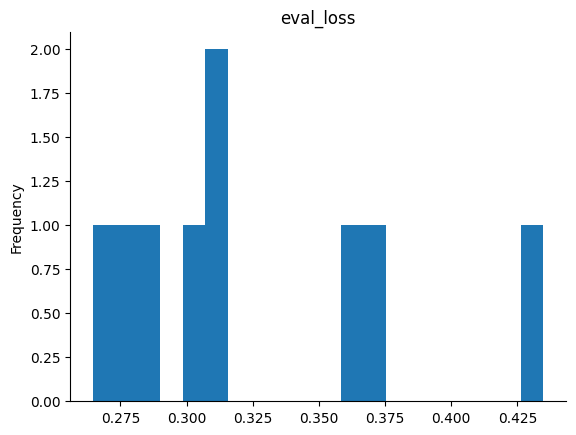

In [ ]:
# @title eval_loss

import pandas as pd
from matplotlib import pyplot as plt

results_df = pd.DataFrame([
    {"model": "AfriBERTa Zulu", **afri_results_zulu},
    {"model": "AfriBERTa Xhosa", **afri_results_xhosa},
    {"model": "AfriBERTa Swahili", **afri_results_swahili},
    {"model": "XLM-R Zulu", **xlmr_results_zulu},
    {"model": "XLM-R Xhosa", **xlmr_results_xhosa},
    {"model": "XLM-R Swahili", **xlmr_results_swahili},
    {"model": "Serengeti Zulu", **serengeti_results_zulu},
    {"model": "Serengeti Xhosa", **serengeti_results_xhosa},
    {"model": "Serengeti Swahili", **serengeti_results_swahili}
])

results_df['eval_loss'].plot(kind='hist', bins=20, title='eval_loss')
plt.gca().spines[['top', 'right',]].set_visible(False)